# Generative Learning - Generating Fashion MNIST images with DCGAN
- uses unsupervised learning
![gan](./gan.jpeg)

In [19]:
import torch
from torch import optim
from torch.utils.data import DataLoader
import torch.nn as nn

from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

## Data Processing

In [ ]:
CODING_SIZE=100 # size of initial random input vector (latent code or noise value)
BATCH_SIZE=32
IMAGE_SIZE=64

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

In [5]:
dataset = datasets.FashionMNIST(
    './',
    train=True,
    download=True,
    transform=transform
)

In [6]:
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

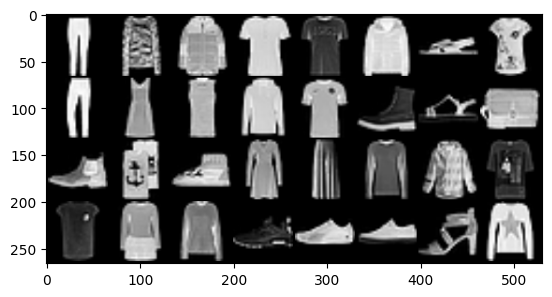

In [ ]:
# Display a batch of images as demo
data_batch, labels_batch = next(iter(dataloader))   # grab a batch for dataloader
grid_img = make_grid(data_batch, nrow=8)
plt.imshow(grid_img.permute(1,2,0))                 # permute ch x h x w => h x w x ch

## Model Design
- goal of GAN model is to generate "fake" data based on the training data's distribution
- GAN uses 2 distinct modules
    - Generator
    - Discriminator
- using DCGAN (Deep Convolutional GAN)
- research
    - [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)
    - [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434)

In [ ]:
class Generator(nn.Module):
    def __init__(self, coding_sz):
        super(Generator, self).__init__()
        # deconvolutional layer for upsampling (increasing spatial dim)
        self.net = nn.Sequential(
            # takes input noise vector of coding_sz (1D tensor)
            # transforms into 2D feature map
            # output of 1024 channels, kernel size:4, stride:1, pad:0
            # spatial dimension 4x4
            nn.ConvTranspose2d(coding_sz, 1024, 4, 1, 0), 
            # normalizes output of convolutional layer to stablize training
            nn.BatchNorm2d(1024),
            # activation function to introduce non-linearity
            nn.ReLU(),
            # halves channels to 512
            # doubles spatial dimensions to 8x8 with stride:2, pad: 1
            nn.ConvTranspose2d(1024,512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # halves channels to 256
            # doubles spatial dimensions to 16x16
            nn.ConvTranspose2d(512,256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # halves channels to 128
            # doubles spatial dimensions to 32x32
            nn.ConvTranspose2d(256,128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # reduce channel down to 1 (grayscale image)
            # doubles spatial dimensios to 64x64
            nn.ConvTranspose2d(128,1, 4, 2, 1),
            # hyperbolic tangent as final activation function
            # scales output pixel values to range of -1 to 1
            nn.Tanh()
        )

    def forward(self, input):
            return( self.net(input) )

In [12]:
netG = Generator(CODING_SIZE).to(device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # input image with 1 channel (grayscale)
            # output 128 channels, kernel size:4, stride:2, pad:1
            # this halves the height and width of input image
            nn.Conv2d(1, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),
            # halves spatial dimension and doubles channels to 256
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # halves spatial dimension and doubles channels to 512
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # halves spatial dimension and doubles channels to 1024
            nn.Conv2d(512, 1024, 4, 2, 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            # reduces to 1 channels and applies 4x4 kernel to 4x4 input feature map, which results in single value
            nn.Conv2d(1024, 1, 4, 1, 0),
            # final activation function 
            # - maps single value output to range 0 to 1
            # - can be interpreted as probability: 
            #   - close to 1 real, close to 0 is fake
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.net(input)

In [14]:
netD = Discriminator().to(device)

In [ ]:
# author of DCGAN finds it helpful to initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

## Training
- in each epoch, 
    - train discriminator with a real batch of data
    - use generator to create a fake batch
    - train discriminator with the generated fake batch of data
    - train generator to produce better fakes

In [17]:
criterion = nn.BCELoss()

In [20]:
optimizerG = optim.Adam(
    netG.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999)
)

In [21]:
optimizerD = optim.Adam(
    netD.parameters(),
    lr=0.0002,
    betas=(0.5, 0.999)
)

In [ ]:
# torch.full creates tensor of specified size and fill with specified value
# - 1: for real
real_labels = torch.full(
    (BATCH_SIZE,),
    1.,
    dtype=torch.float,
    device=device
)

In [ ]:
# torch.full creates tensor of specified size and fill with specified value
# - 0: for fake
fake_labels = torch.full(
    (BATCH_SIZE,),
    0.,
    dtype=torch.float,
    device=device
)

In [24]:
G_losses = []
D_losses = []
D_real = []
D_fake = []

In [25]:
z = torch.randn((BATCH_SIZE, 100)).view(-1, 100, 1, 1).to(device)
test_out_images = []

In [27]:
N_EPOCHS=5

In [ ]:
for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch}')
    for i, batch in enumerate(dataloader):
        if (i%200 == 0):
            print(f'batch: {i} of {len(dataloader)}')
        
        # Train Discriminator with an all-real batch
        netD.zero_grad()
        ## loads a batch of real images
        ## scale from typical [0,1] range to [-1, 1] to match output range of generator's tanh function
        real_images = batch[0].to(device) * 2. - 1. 
        ## discrimator processes real images
        ## output (single value 0-1) is flattened
        ## -1 tells pytorch to auto infer size 
        output = netD(real_images).view(-1)
        ## loss function calculates error between 
        ## - discriminators output and real_labels
        errD_real = criterion(output, real_labels)
        ## stores average output from discriminator for real images
        ## - which should be close to 1 if performing well
        D_x = output.mean().item()

        # Train Discriminator with an all-fake batch
        noise = torch.randn((BATCH_SIZE,CODING_SIZE))
        noise = noise.view(-1, 100, 1, 1).to(device)
        ## generator creates batch of fake images from noise
        fake_images = netG(noise)
        ## discriminator processes the generated fake images
        output = netD(fake_images).view(-1)
        errD_fake = criterion(output, fake_labels)
        D_G_z1 = output.mean().item()
        ## total discriminator loss (losses for real + fake)
        errD = errD_real + errD_fake
        ## backwards propagation
        ## - calculates gradients for discriminator's weights based on total loss
        errD.backward(retain_graph=True)
        ## discriminator's weights are updated per calculated gradients
        optimizerD.step()

        # Train Generator to generate better fakes
        netG.zero_grad()
        ## generator output (fake_images) is fed back into discriminator
        output = netD(fake_images).view(-1)
        ## generator's loss is calculated using discriminator's output and real_labels (tensor of all 1s)
        ## this makes generator's objective to produce images that are convincing enough to make discriminator's output for them close to 1
        errG = criterion(output, real_labels)
        errG.backward()
        ## store average output from discriminator after generator's weights have been updated
        ## this value should be close to 1 if generator is improving
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        D_real.append(D_x)
        D_fake.append(D_G_z2)
    
    ## at end of each epoch
    ## - fixed noised vector(z) passed to generator to produce test image
    test_images = netG(z).to('cpu').detach()
    test_out_images.append(test_images)

Epoch: 0
batch: 0 of 1875


libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x1189d93a0>
Traceback (most recent call last):
  File "/Users/jasonlau/.pyenv/versions/3.11.11/envs/deeplearn/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/Users/jasonlau/.pyenv/versions/3.11.11/envs/deeplearn/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1582, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/jasonlau/.pyenv/versions/3.11.11/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jasonlau/.pyenv/versions/3.11.11/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wa

KeyboardInterrupt: 

In [ ]:
torch.save(netG.state_dict(), './gan.pt')